In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. 데이터 로드

In [23]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [3]:
train.shape, test.shape, submission.shape
train.head(3)
test.head(3)
submission.head(3)

((45532, 77), (11383, 76), (11383, 1))

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,...,0,1,0,1,1,0,1,0,1,1
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,...,1,1,0,1,1,0,1,0,1,1
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,...,1,1,0,1,1,1,1,0,1,1


,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,736,2.0,2941,3.0,4621,1.0,4857,2.0,2550,...,0,1,0,0,1,0,1,0,1,1
1,3.0,514,2.0,1952,3.0,1552,3.0,821,4.0,1150,...,0,0,0,0,0,0,0,0,0,0
2,3.0,500,2.0,2507,4.0,480,2.0,614,2.0,1326,...,0,1,0,1,1,0,1,0,1,1


,voted
index,
0,0
1,0
2,0


# 2. EDA & 전처리

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
train.info

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## Target 분포

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))

train['voted'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
sns.countplot('voted', data=train, ax=ax[1])

plt.show()

# 균일

## Target Encoding

### age_group

In [33]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [34]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [35]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [28]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [36]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [37]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

## Outlier

In [ ]:
test.familysize.max(), test.familysize.mean(), train[train.familysize < 30]['familysize'].mean()

In [ ]:
train[train.familysize > 20]['familysize'].value_counts().sort_values(ascending=False)

In [38]:
train.loc[train[train.familysize > 25].index, 'familysize'] = 2.6

In [ ]:
train['familysize'].value_counts()

## 인코딩

In [ ]:
#age_group, gender, race, religion
#train['age_group'] = train['age_group'].str.replace('s','').astype('int')
train['gender']= pd.factorize(train['gender'])[0]
train['race']=pd.factorize(train['race'])[0]
train['religion']=pd.factorize(train['religion'])[0]

#test['age_group'] = test['age_group'].str.replace('s','').astype('int')
test['gender']=pd.factorize(test['gender'])[0]
test['race']=pd.factorize(test['race'])[0]
test['religion']=pd.factorize(test['religion'])[0]

### One-hot

In [ ]:
train = pd.get_dummies(train, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
train

In [ ]:
test = pd.get_dummies(test, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
test

In [ ]:
train.shape, test.shape
train.columns.values
test.columns.values

# 3. 모델 학습

In [16]:
from pycaret.classification import *

In [17]:
import gc
gc.collect()

48

In [40]:
%%time
clf = setup(data = train, target = 'voted', polynomial_features=True
          , categorical_features=['age_group','gender','race','religion']
            #,ignore_features =['age_group_mean_smoothing']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,6059
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45532, 78)"
4,Missing Values,False
5,Numeric Features,42
6,Categorical Features,35
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 13.7 s


In [41]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6922,0.7639,0.6400,0.7593,0.6945,0.3889,0.3947,30.0206
1,Light Gradient Boosting Machine,0.6920,0.7628,0.6454,0.7556,0.6961,0.3877,0.3927,1.4399
2,CatBoost Classifier,0.6915,0.7646,0.6562,0.7485,0.6993,0.3853,0.3888,24.0546
3,Linear Discriminant Analysis,0.6906,0.7595,0.6622,0.7439,0.7006,0.3827,0.3855,0.9898
4,Ridge Classifier,0.6904,0.0000,0.6624,0.7435,0.7006,0.3824,0.3852,0.2028
5,Ada Boost Classifier,0.6881,0.7556,0.6489,0.7474,0.6946,0.3791,0.3831,6.9247
6,Extra Trees Classifier,0.6876,0.7579,0.6335,0.7557,0.6892,0.3800,0.3860,3.8046
7,Extreme Gradient Boosting,0.6749,0.7433,0.6653,0.7192,0.6912,0.3492,0.3504,13.7340
8,Random Forest Classifier,0.6538,0.7102,0.5952,0.7229,0.6528,0.3140,0.3200,0.4952
9,Decision Tree Classifier,0.6138,0.6104,0.6468,0.6469,0.6468,0.2207,0.2207,2.1570


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=6059, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [42]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors.KNeighborsClassifier,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model.SGDClassifier,True
rbfsvm,SVM - Radial Kernel,sklearn.svm.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process.GPC,False
mlp,MLP Classifier,sklearn.neural_network.MLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model.RidgeClassifier,True


## turn model

In [43]:
gbc  = create_model('gbc')    
tuned_gbc = tune_model(gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6935,0.7537,0.6529,0.7536,0.6997,0.3901,0.3943
1,0.6807,0.7397,0.6523,0.7340,0.6908,0.3630,0.3657
2,0.6825,0.7575,0.6464,0.7398,0.6900,0.3676,0.3711
3,0.6818,0.7480,0.6556,0.7339,0.6925,0.3651,0.3676
4,0.6655,0.7265,0.6299,0.7228,0.6732,0.3340,0.3373
5,0.6705,0.7401,0.6305,0.7302,0.6767,0.3445,0.3484
6,0.6894,0.7638,0.6523,0.7475,0.6967,0.3814,0.3851
7,0.6941,0.7666,0.6701,0.7449,0.7055,0.3891,0.3914
8,0.6862,0.7569,0.6483,0.7449,0.6933,0.3753,0.3791
9,0.6922,0.7636,0.6718,0.7411,0.7048,0.3849,0.3869


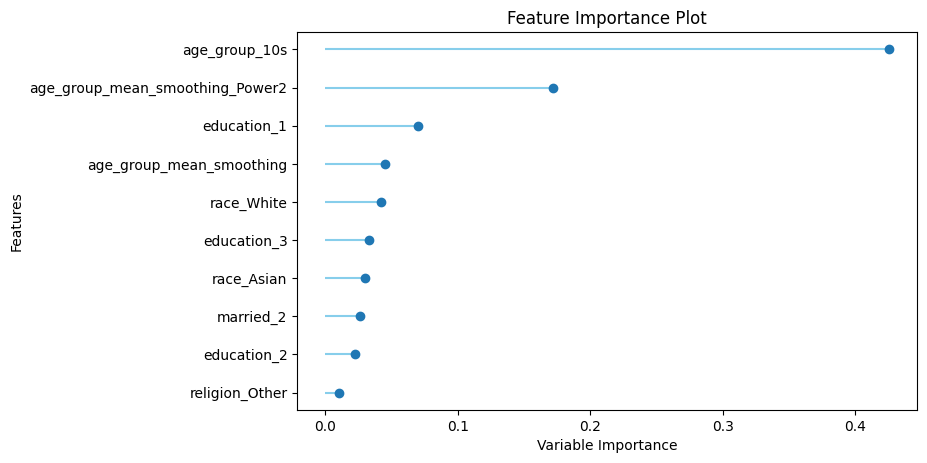

In [44]:
plot_model(estimator = gbc, plot = 'feature')

In [45]:
lightgbm  = create_model('lightgbm') 
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6907,0.7503,0.6586,0.7459,0.6996,0.3834,0.3866
1,0.6785,0.7451,0.6592,0.7272,0.6915,0.3575,0.3594
2,0.6781,0.7543,0.6625,0.7249,0.6923,0.3562,0.3578
3,0.6843,0.7620,0.6596,0.7356,0.6955,0.3698,0.3722
4,0.6730,0.7339,0.6506,0.7237,0.6852,0.3471,0.3492
5,0.6756,0.7490,0.6546,0.7254,0.6882,0.3519,0.3539
6,0.6862,0.7617,0.6598,0.7386,0.6970,0.3738,0.3764
7,0.6922,0.7657,0.6758,0.7390,0.7060,0.3844,0.3860
8,0.6928,0.7575,0.6690,0.7436,0.7043,0.3866,0.3889
9,0.6966,0.7655,0.6758,0.7456,0.7090,0.3936,0.3957


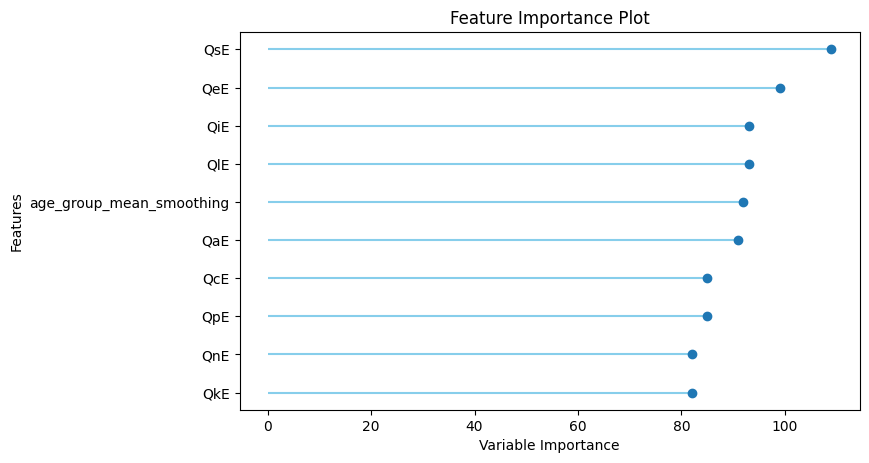

In [46]:
plot_model(estimator = lightgbm, plot = 'feature')

In [47]:
catboost  = create_model('catboost') 
tuned_catboost = tune_model(catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6957,0.7634,0.6431,0.7631,0.6980,0.3959,0.4018
1,0.6848,0.7536,0.6472,0.7431,0.6918,0.3723,0.3760
2,0.6865,0.7625,0.6475,0.7455,0.6931,0.3760,0.3799
3,0.6944,0.7690,0.6447,0.7598,0.6975,0.3929,0.3983
4,0.6793,0.7495,0.6397,0.7389,0.6857,0.3618,0.3657
5,0.6831,0.7559,0.6443,0.7422,0.6898,0.3692,0.3730
6,0.7041,0.7728,0.6638,0.7642,0.7105,0.4110,0.4152
7,0.7038,0.7742,0.6632,0.7640,0.7101,0.4104,0.4147
8,0.6988,0.7717,0.6558,0.7605,0.7043,0.4007,0.4053
9,0.7085,0.7764,0.6736,0.7653,0.7165,0.4190,0.4227


In [ ]:
ridge  = create_model('ridge') 
tuned_ridge = tune_model(ridge)

In [ ]:
plot_model(estimator = ridge, plot = 'feature')

In [48]:
turns = [tuned_gbc, tuned_lightgbm, tuned_catboost]#, tuned_ridge]

In [ ]:
%%time
best_3 = compare_models(sort = 'AUC', n_select = 5)

In [49]:
#blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')
blended = blend_models(estimator_list = turns, fold = 5, optimize='AUC', method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6864,0.7559,0.6391,0.7504,0.6903,0.3769,0.3819
1,0.6936,0.7660,0.6515,0.7547,0.6993,0.3905,0.3949
2,0.6807,0.7517,0.6410,0.7402,0.6871,0.3646,0.3686
3,0.6971,0.7695,0.6617,0.7541,0.7049,0.3964,0.4000
4,0.6980,0.7687,0.6581,0.7578,0.7044,0.3988,0.4030
Mean,0.6912,0.7624,0.6503,0.7515,0.6972,0.3854,0.3896
SD,0.0066,0.0072,0.0090,0.0061,0.0073,0.0129,0.0128


In [50]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6952,0.766,0.6474,0.7598,0.6991,0.3943,0.3995


In [51]:
final_model = finalize_model(blended)

In [ ]:
final_model

In [52]:
predictions = predict_model(final_model, data = test)

In [53]:
submission['voted'] = predictions['Score']

In [54]:
submission.to_csv('output/20200929-2.csv')

## train, valid 데이터

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('voted', axis = 1), train['voted'], test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

## 하이퍼파라미터 튜닝

In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, plot_importance

colsample_bytree': 0.9606396547156734
, 'max_bin': 164.7465545875555
, 'max_depth': 11.107229265820779
, 'min_child_samples': 198.98606348612637
, 'min_child_weight': 41.32364031573033
, 'num_leaves': 49.45519154750152
, 'reg_alpha': 0.8758415725587487
, 'reg_lambda': 8.299355787002883
, 'subsample': 0.6598579157665245}}

In [ ]:
# parameter 별로 search할 범위를 설정. 
bayesian_params = {
    'max_depth': (6, 16), 
    'num_leaves': (10, 100), 
    'min_child_samples': (10, 500), 
    'min_child_weight':(1, 100),
    'subsample':(0.1, 1.0),
    'colsample_bytree': (0.1, 1.0),
    'max_bin':(10, 1000),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

In [ ]:
def lgb_roc_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        #"n_estimators":500, "learning_rate":0.02,
        "n_estimators":1000, "learning_rate":0.001,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    valid_proba = lgb_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, valid_proba)
    
    return roc_auc   

In [ ]:
import gc
gc.collect()

In [ ]:
%%time
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_roc_eval,bayesian_params , random_state=42)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=10, n_iter=50)

In [ ]:
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

* test_size=0.3
{'target': 0.7655615473679408, 'params': {'colsample_bytree': 0.737265320016441, 'max_bin': 30.378649352844423, 'max_depth': 15.699098521619943, 'min_child_samples': 417.8968939922066, 'min_child_weight': 22.02157195714934, 'num_leaves': 26.364247048639054, 'reg_alpha': 9.178391447573157, 'reg_lambda': 3.043118187352418, 'subsample': 0.5722807884690141}}

- outlier 삭제 
{'target': 0.7652209584768751, 'params': {'colsample_bytree': 0.5703824815639528, 'max_bin': 15.404309116854074, 'max_depth': 13.17919661428763, 'min_child_samples': 24.998278489695448, 'min_child_weight': 97.74061068693372, 'num_leaves': 99.35614131954165, 'reg_alpha': 1.2926370490809749, 'reg_lambda': 1.1059679925299122, 'subsample': 0.4274854420066033}}

- outlier 2.6 
{'target': 0.7655617202045278, 'params': {'colsample_bytree': 0.737265320016441, 'max_bin': 30.378649352844423, 'max_depth': 15.699098521619943, 'min_child_samples': 417.8968939922066, 'min_child_weight': 22.02157195714934, 'num_leaves': 26.364247048639054, 'reg_alpha': 9.178391447573157, 'reg_lambda': 3.043118187352418, 'subsample': 0.5722807884690141}}

In [ ]:
clf = LGBMClassifier(
        n_jobs=-1
        ,nthread=4
        ,n_estimators=1000
        ,learning_rate=0.02
        ,max_depth = 16
        ,num_leaves=47
        ,colsample_bytree=0.56
        ,subsample=0.55
        ,max_bin=30
        ,reg_alpha=0.23
        ,reg_lambda=0.03
        ,min_child_weight=70
        ,min_child_samples=169
        ,silent=-1
        ,verbose=-1
        ,random_state=42
        )

clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
eval_metric= 'auc', verbose= 100, early_stopping_rounds= 50)

In [ ]:
plot_importance(clf, figsize=(16, 32))

# 4. 예측

In [ ]:
pred_y  = clf.predict(test)

In [ ]:
submission['voted'] = pred_y 

In [ ]:
submission

# 5. 제출

In [ ]:
submission.to_csv('output/20200928-1.csv')